In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import heapq
import torch
import torch.optim as optim

In [16]:
def generate_random_graph(num_nodes, edge_probability):

    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if random.random() < edge_probability:
                weight = round(random.uniform(2.8, 9), 2)
                G.add_edge(i, j, weight=weight)

    return G


def plot_graph(G, path=None, title="Graph Visualization", start_node=None, end_node=None):
    print("\n\n")
    pos = nx.spring_layout(G, seed=712)
    plt.figure(figsize=(10, 8))  # Larger graph size
    nx.draw(G, pos, with_labels=True, node_size=200, node_color="skyblue", edge_color="gray")  # Larger nodes

    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)

    if start_node:
        nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color="green", node_size=200)  # Highlight start node
    if end_node:
        nx.draw_networkx_nodes(G, pos, nodelist=[end_node], node_color="red", node_size=200)  # Highlight end node

    plt.title(title)
    plt.show()

> a star

In [17]:
def a_star_search(G, start, goal):

    open_set = set([start])  # Nodes to be evaluated
    closed_set = set()  # Nodes already evaluated

    came_from = {}  # Store parent nodes for path reconstruction

    g_score = {node: float('inf') for node in G.nodes}  # Cost from start to node
    g_score[start] = 0

    f_score = {node: float('inf') for node in G.nodes}  # Estimated total cost
    f_score[start] = heuristic(start, goal)  # Initialize with heuristic

    while open_set:
        current = min(open_set, key=lambda node: f_score[node])  # Node with lowest f_score

        if current == goal:
            path = []
            while current is not None:
                path.append(current)
                # Check if current exists as a key in came_from before accessing
                current = came_from.get(current, None)  # This line is modified to handle KeyError
            path.reverse()
            return path

        open_set.remove(current)
        closed_set.add(current)

        for neighbor in G.neighbors(current):
            if neighbor in closed_set:
                continue  # Ignore already evaluated neighbors

            tentative_g_score = g_score[current] + G[current][neighbor].get('weight', 1)  # Default weight 1

            if neighbor not in open_set:
                open_set.add(neighbor)
            elif tentative_g_score >= g_score[neighbor]:
                continue  # Not a better path

            came_from[neighbor] = current
            g_score[neighbor] = tentative_g_score
            f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)

    return []  # Return empty list if no path found

def heuristic(a, b):
    return 1

In [18]:
def time_varying_loss(path_length, time_factor):
    return torch.tensor(path_length) * torch.tensor(time_factor)

def risk_averse_loss(path, G, risk_factor, uncertainty_factor):
    risk_penalty = 0
    for i in range(len(path) - 1):
        edge_data = G[path[i]][path[i + 1]]
        base_risk = edge_data.get('risk', 0)  # Base risk from edge data
        uncertainty_risk = uncertainty_factor * edge_data.get('uncertainty', 0)  # Uncertainty-based risk
        risk_penalty += base_risk + uncertainty_risk
    return torch.tensor(risk_penalty, dtype=torch.float32)

def simulate_environment(G, steps=1, move_probability=0.38, risk_factor=1.0):
    for _ in range(steps):
        for node in G.nodes():
            if random.random() < move_probability:
                # Simulate a node change or movement by modifying edge weights
                for neighbor in G.neighbors(node):
                    new_weight = random.uniform(1, 5) * (1 + random.uniform(-0.2, 0.2))
                    # Apply risk and energy constraints
                    risk_adjustment = new_weight * risk_factor

                    # Update the edge weight considering the uncertainties and constraints
                    G[node][neighbor]['weight'] = risk_adjustment

In [19]:
def plot_losses(loss_history, optimizer_name):  # Added optimizer_name argument
    epochs = list(range(len(loss_history["total"])))
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, loss_history["time"], label="Time Loss")
    plt.plot(epochs, loss_history["risk"], label="Risk Loss")
    plt.plot(epochs, loss_history["total"], label="Total Loss", linestyle="--", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss Optimization Over Time - Optimizer: {optimizer_name}")  # Add optimizer name to title
    plt.show()

In [28]:
def run_experiment(forestfire_graph, nodes, edge_probability, start_node, goal_node):
    time_factor=1.0
    risk_factor=1.0
    epochs=50
    uncertainty_factor=0.5

    print(f"Start node: {start_node}, Goal node: {goal_node}")

    optimizers = {
        "SGD": lambda params: optim.SGD(params, lr=0.01),
        "Adam": lambda params: optim.Adam(params, lr=0.01),
        "RMSprop": lambda params: optim.RMSprop(params, lr=0.01),
    }

    for optimizer_name, optimizer_func in optimizers.items():
        path = a_star_search(forestfire_graph, start_node, goal_node)
        print(f"Initial Path ({optimizer_name}):", path)

        # Initial Loss Calculation
        time_loss = time_varying_loss(len(path), time_factor).clone().detach().requires_grad_(True)
        risk_loss = risk_averse_loss(path, forestfire_graph, risk_factor, uncertainty_factor).clone().detach().requires_grad_(True)

        # Setup optimizer and loss tracking
        optimizer = optimizer_func([time_loss, risk_loss])
        loss_history = {"time": [], "risk": [], "total": []}
        paths_over_time = []

        for epoch in range(epochs):
            simulate_environment(forestfire_graph, steps=1, move_probability=0.38, risk_factor=risk_factor)
            optimizer.zero_grad()
            total_loss = time_loss + risk_loss
            total_loss.backward()
            optimizer.step()

            # Recalculate path with updated losses
            path = a_star_search(forestfire_graph, start_node, goal_node)
            paths_over_time.append(path)

            # Recalculate individual losses for the new path
            time_loss = time_varying_loss(len(path), time_factor).clone().detach().requires_grad_(True)
            risk_loss = risk_averse_loss(path, forestfire_graph, risk_factor, uncertainty_factor).clone().detach().requires_grad_(True)


            # Record losses for visualization (but don't print)
            loss_history["time"].append(time_loss.item())
            loss_history["risk"].append(risk_loss.item())
            loss_history["total"].append(total_loss.item())

        # Visualize Path Evolution and Losses for the Optimizer
        print(f"Optimizing path using {optimizer_name} optimizer")
        plot_graph(forestfire_graph, path=path, title=f"Optimized Path ({optimizer_name})")
        plot_losses(loss_history, optimizer_name)  # Plot losses over epochs

adjust the edge probability and nodes by taking input from user

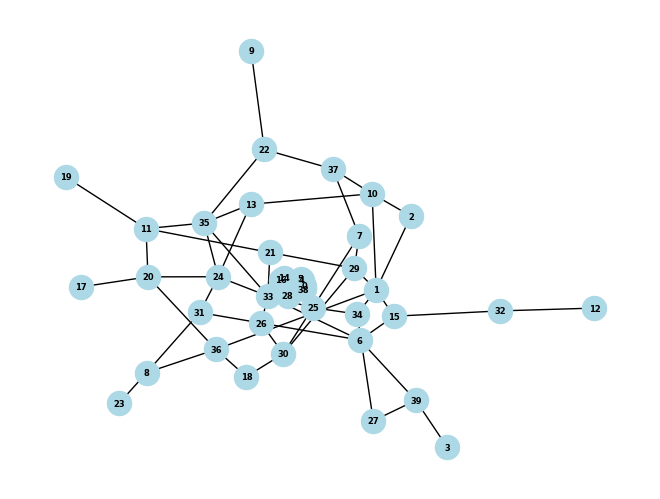

In [21]:
edge_probability = 0.06 # float(input())
nodes = 40 # int(input())
forestfire_graph = generate_random_graph(nodes, edge_probability)

#kamada kawai layout
pos = nx.kamada_kawai_layout(forestfire_graph)
nx.draw(forestfire_graph, pos, with_labels=True, node_color='lightblue', font_size=6, font_weight='bold', edge_color='black', width=1)
plt.show()

In [22]:
start_node = int(input())
goal_node = int(input())

30
18


Start node: 30, Goal node: 18
Initial Path (SGD): [30, 18]
Optimizing path using SGD optimizer





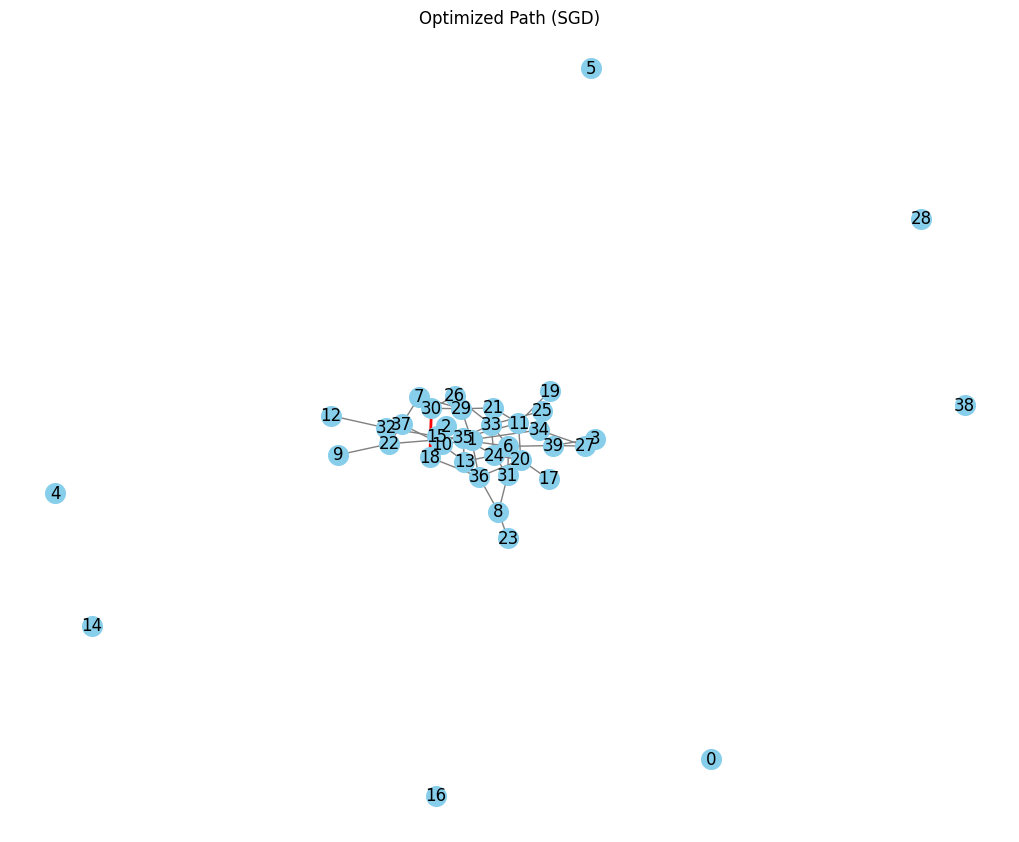

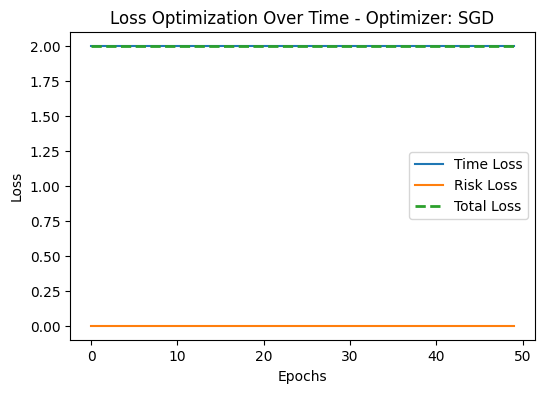

Initial Path (Adam): [30, 18]
Optimizing path using Adam optimizer





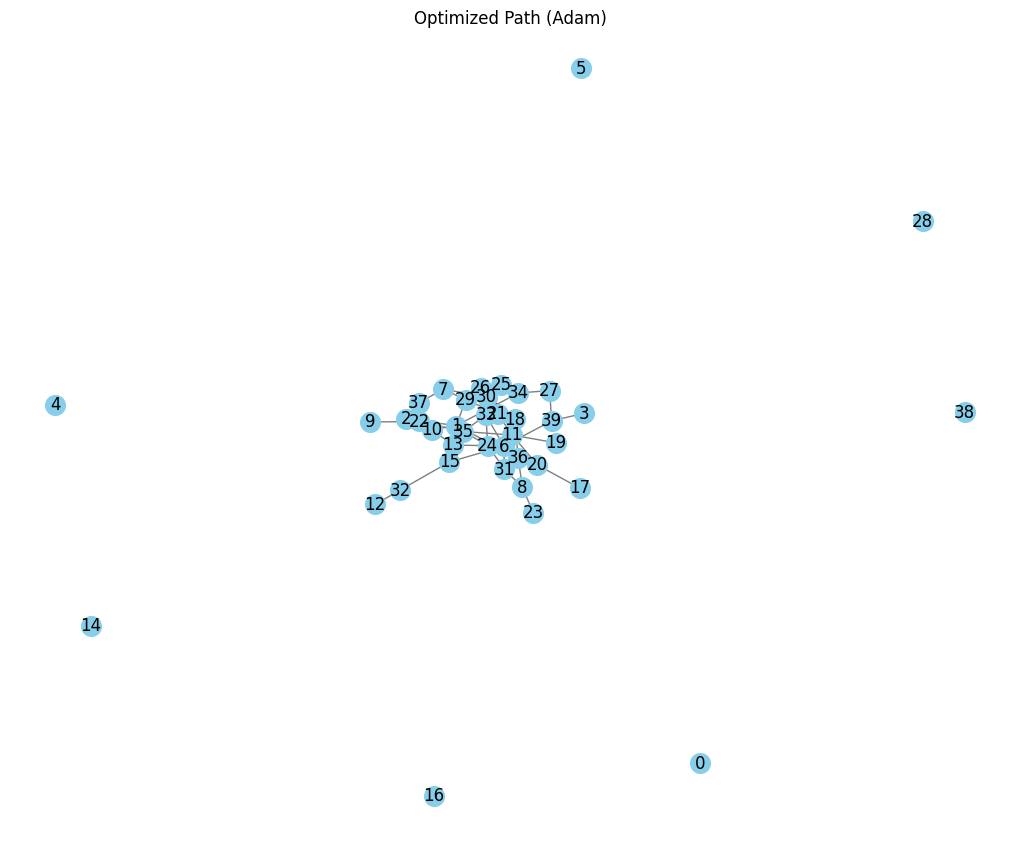

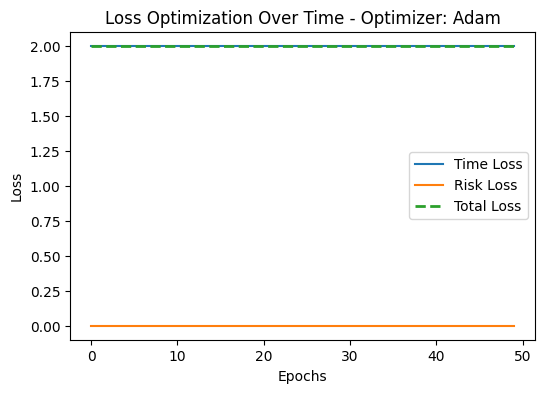

Initial Path (RMSprop): [30, 18]
Optimizing path using RMSprop optimizer





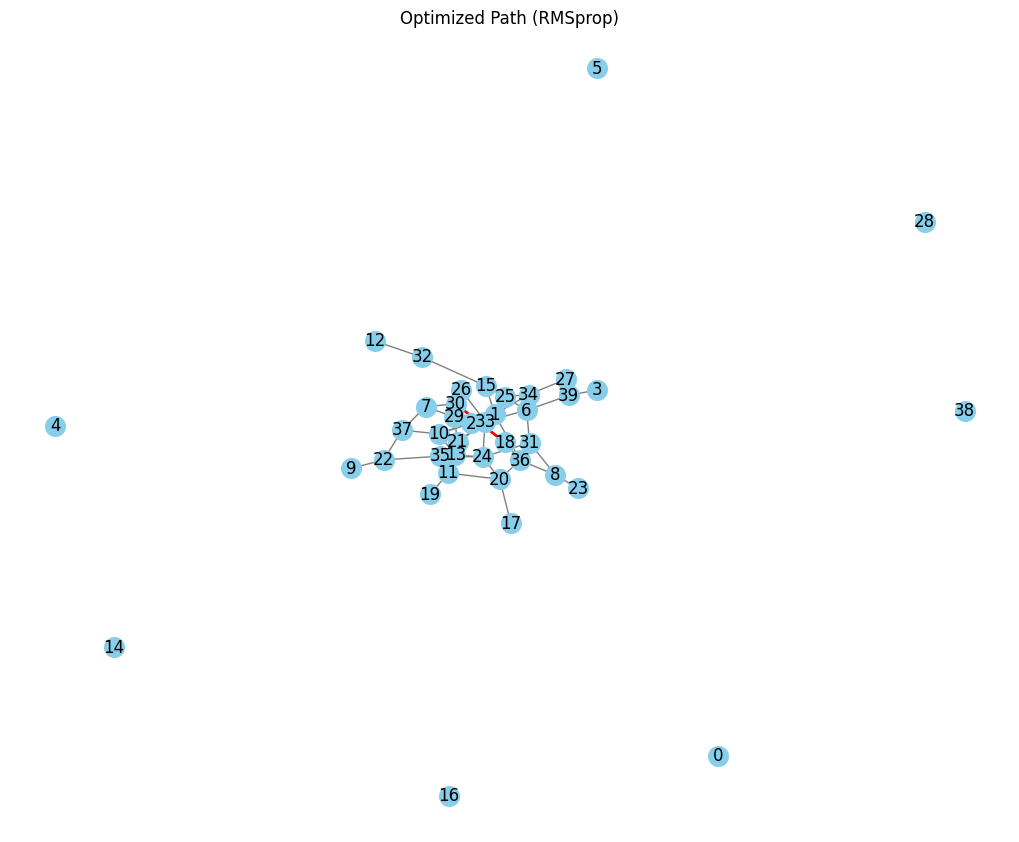

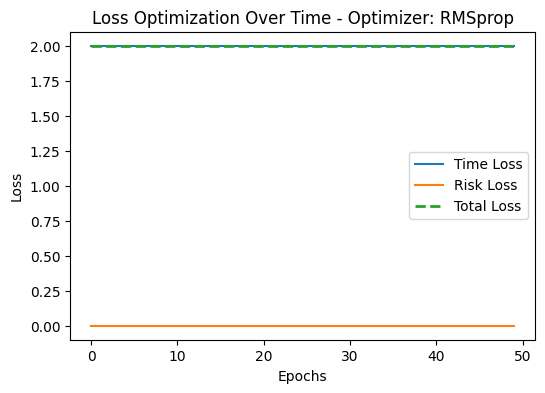

In [27]:
run_experiment(forestfire_graph,nodes, edge_probability,start_node, goal_node)